In [87]:
import os
import fitz  # PyMuPDF
import re
from PIL import Image
import io
import numpy as np
from multi_coulumn import column_boxes
import matplotlib.pyplot as plt

In [169]:
doc = fitz.open('./Data/Exter.pdf') ## Replace Path with your own PDF Path

[+] Found a total of 1 images in page 125
Pixmap(ICCBased(RGB,sRGB IEC61966-2.1), (0, 0, 206, 160), 0)
Colorspace(CS_RGB) - ICCBased(RGB,sRGB IEC61966-2.1)
(0, 0, 206, 160)


2385
[[[236 236 236]
  [236 236 236]
  [236 236 236]
  ...
  [236 236 236]
  [236 236 236]
  [236 236 236]]

 [[236 236 236]
  [236 236 236]
  [236 236 236]
  ...
  [236 236 236]
  [236 236 236]
  [236 236 236]]

 [[236 236 236]
  [236 236 236]
  [236 236 236]
  ...
  [236 236 236]
  [236 236 236]
  [236 236 236]]

 ...

 [[236 236 236]
  [236 236 236]
  [236 236 236]
  ...
  [236 236 236]
  [236 236 236]
  [236 236 236]]

 [[236 236 236]
  [236 236 236]
  [236 236 236]
  ...
  [236 236 236]
  [236 236 236]
  [236 236 236]]

 [[236 236 236]
  [236 236 236]
  [236 236 236]
  ...
  [236 236 236]
  [236 236 236]
  [236 236 236]]]


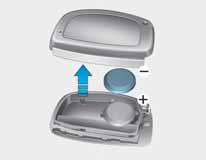

In [170]:
page_index = 125
page = doc[page_index]
image_list = page.get_images(full=False) 

# printing number of images found in this page 
if image_list: 
    print( 
        f"[+] Found a total of {len(image_list)} images in page {page_index}") 
else: 
    print("[!] No images found on page", page_index) 
for image_index, img in enumerate(page.get_images(), start=1): 

    # get the XREF of the image 
    xref = img[0] 

    # extract the image bytes 
    pix = fitz.Pixmap(doc,xref) 

    # get the image extension 
    if pix.n - pix.alpha > 3: # CMYK: convert to RGB first
            pix = fitz.Pixmap(fitz.csRGB, pix)

    # pix.save("./Images/page_%s-image_%s.png" % (page_index, image_index)) # save the image as png
    # pix = None
    print(pix)
    print(pix.colorspace)
    print(pix.irect)
    print(pix.color_count())
    image_bytes = pix.tobytes()
    image = Image.open(io.BytesIO(image_bytes))

# Display the image
    image_array = np.array(image)
    if(len(np.unique(image_array))!=1):
        print(np.array(image))
        display(image)
    
    

In [142]:

def detect_tables(page): ## Detects tables in page
    tables = page.find_tables(horizontal_strategy="lines", vertical_strategy="lines")
    return tables
def find_min(group): ## Finds minimum coordinate value of bounding box group
    sorted_group = sorted(group,key=lambda x:x.bbox[0])
    return sorted_group[0].bbox[0]

In [34]:
def normalize_text(text):
    # Remove line breaks and extra spaces
    if(text == None):
        return
    text = text.replace('\n', ' ').strip()
    # Lowercase the text
    text = text.lower()
    # Standardize punctuation
    text = text.replace(' ,', ',').replace(' .', '.').replace(' ?', '?').replace(' !', '!')
    # Replace placeholders (if any)
    # No placeholders to replace in the provided text
    return text

In [33]:
def group_coordinates(coordinates, threshold,tables):
    groups = []
    current_group = []

    # Sort the coordinates based on the x-coordinate
    sorted_coordinates = sorted(coordinates, key=lambda x: x[0])

    # Iterate through sorted coordinates
    for i in range(len(sorted_coordinates)):
        if i == 0:
            current_group.append(sorted_coordinates[i])
        else:
            # Check the difference between consecutive x-coordinates
            diff = sorted_coordinates[i][0] - sorted_coordinates[i-1][0]
            if diff <= threshold:
                # Add coordinate to the current group
                current_group.append(sorted_coordinates[i])
            else:
                # Start a new group
                if tables.tables:
                    for table in tables:
                        min_x = find_min(current_group)
                        if min_x<int(table.bbox[0]):
                            groups.append(current_group)
                else:
                    groups.append(current_group)
                current_group = [sorted_coordinates[i]]

    # Add the last group
    if tables.tables:
        for table in tables:
            min_x = find_min(current_group)
            if min_x<int(table.bbox[0]):
                groups.append(current_group)
    else:
        groups.append(current_group)
    return groups

In [63]:
class Box:
    def __init__(self, bbox, data,type):
        self.type = type
        self.bbox = bbox
        self.data = data

{'number': 35, 'bbox': (403.0870056152344, 90.0889892578125, 565.9539794921875, 219.04498291015625), 'transform': (162.86700439453125, 0.0, -0.0, -128.95599365234375, 403.0870056152344, 219.04498291015625), 'width': 679, 'height': 538, 'colorspace': 1, 'cs-name': 'DeviceGray', 'xres': 96, 'yres': 96, 'bpc': 8, 'size': 99593, 'digest': b'.\x06P\xa9\x1b\x9cd[\x90\xd8\xa8\xbc\x7f\xf45\xd1', 'xref': 897}
[[ 43  42  42 ... 148 148 148]
 [ 44  43  43 ... 148 148 148]
 [ 42  42  41 ... 148 148 148]
 ...
 [ 36  38  37 ...  81  36  46]
 [ 36  35  37 ...  33  48  54]
 [ 36  35  38 ...  43  52  55]]


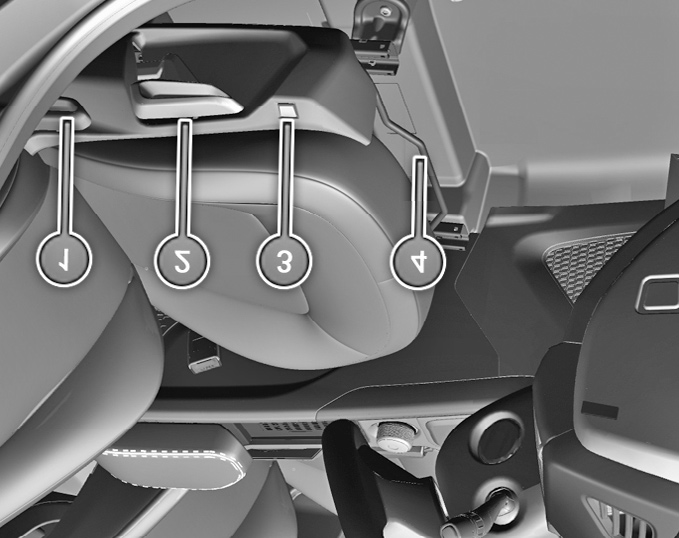

In [62]:
page = doc.load_page(125)
images = page.get_image_info(xrefs=True)
for image in images:
    xref = image["xref"]

    # extract the image bytes 
    pix = fitz.Pixmap(doc,xref) 

    # get the image extension 
    if pix.n - pix.alpha > 3: # CMYK: convert to RGB first
            pix = fitz.Pixmap(fitz.csRGB, pix)
    image_bytes = pix.tobytes()
    img = Image.open(io.BytesIO(image_bytes))
    image_array = np.array(img)
    if(len(np.unique(image_array))!=1):
        print(image)
        print(image_array)
        display(img)
        


In [64]:
def get_image_list(page):
    images = page.get_image_info(xrefs=True)
    image_list = []
    for image in images:
        xref = image["xref"]

        # extract the image bytes 
        pix = fitz.Pixmap(doc,xref) 

        # get the image extension 
        if pix.n - pix.alpha > 3: # CMYK: convert to RGB first
                pix = fitz.Pixmap(fitz.csRGB, pix)
        image_bytes = pix.tobytes()
        img = Image.open(io.BytesIO(image_bytes))
        image_array = np.array(img)
        if(len(np.unique(image_array))!=1):
            box = Box(image['bbox'],np.array(img),"image")
            image_list.append(box)
    return image_list
    
    

In [66]:
def get_text_list(page):
    bboxes = column_boxes(page, header_margin=40, no_image_text=True)
    rect_list = []

    for rect in bboxes:
        bbox = rect.rect
        box_string = page.get_text(clip=bbox, sort=True)
        data = normalize_text(box_string)
        box = Box(bbox,data,"text")
        rect_list.append(box)
    return rect_list

In [125]:
def group_coordinates(box_list, threshold,tables):
    groups = []
    current_group = []

    # Sort the coordinates based on the x-coordinate
    sorted_boxes = sorted(box_list, key=lambda x: x.bbox[0])
    # Iterate through sorted coordinates
    for i in range(len(sorted_boxes)):

        if i == 0:
            current_group.append(sorted_boxes[i])
        else:
            # Check the difference between consecutive x-coordinates
            diff = sorted_boxes[i].bbox[0] - sorted_boxes[i-1].bbox[0]
            if diff <= threshold:
                # Add coordinate to the current group
                current_group.append(sorted_boxes[i])
            else:
                # Start a new group
                if tables.tables:
                    for table in tables:
                        min_x = find_min(current_group)
                        if min_x<int(table.bbox[0]):
                            groups.append(current_group)
                else:
                    groups.append(current_group)
                current_group = [sorted_boxes[i]]

    # Add the last group
    if tables.tables:
        for table in tables:
            min_x = find_min(current_group)
            if min_x<int(table.bbox[0]):
                groups.append(current_group)
    else:
        groups.append(current_group)
    return groups

In [ ]:
def read_group(group):
    string = ""
    for rect in group:
        # print(page.get_text(clip=rect, sort=True))
        # print("-" * 80)
        # box_string = page.get_text(clip=rect, sort=True)
        # print(normalize_text(box_string),end='')
        if(rect.type=='image'):
            # plt.imshow(rect.data)
            pass
        else:
            string =string + rect.data
    print(string)
    return string

In [154]:
def is_image_group(group):
    for ind,rect in enumerate(group):
        # print(page.get_text(clip=rect, sort=True))
        # print("-" * 80)
        # box_string = page.get_text(clip=rect, sort=True)
        # print(normalize_text(box_string),end='')
        if(rect.type=='image'):
            # plt.imshow(rect.data)
            return ind
    return -1

In [132]:
group = groups[0]
    ed_grp = sorted(group,key = lambda x:x.bbox[1])
for i in sorted_grp:
    print(i.bbox) 

Rect(116.0, 46.0, 145.0, 61.0)
Rect(47.0, 63.0, 205.0, 97.0)
Rect(42.0, 106.0, 210.0, 331.0)


In [171]:
page = doc.load_page(81)
tables = detect_tables(page)

bboxes = column_boxes(page, header_margin=40, no_image_text=True) ## Finds all the bounding boxes in the page
image_list = get_image_list(page) 
rect_list = get_text_list(page)
# Function to group coordinates based on their x-coordinate values

groups = group_coordinates(rect_list+image_list,70,tables)

for ind,group in enumerate(groups):
    # print(group)
    sorted_group = sorted(group,key=lambda x:x.bbox[1])
    if(is_image_group(sorted_group)):
        if((ind-1)>=0):
            read_group(sorted(groups[ind-1],key=lambda x:x.bbox[1]))
        read_group(sorted(groups[ind],key=lambda x:x.bbox[1]))

        if((ind+1)<len(groups)):
            read_group(sorted(groups[ind+1],key=lambda x:x.bbox[1]))
    # read_group(sorted_group)
    print("-" * 80)



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [172]:
image_dictionary = {}
def image_extractor(doc):
    page_count = doc.page_count

    for i in range(page_count):
        page = doc.load_page(i)
        tables = detect_tables(page)

        bboxes = column_boxes(page, header_margin=40, no_image_text=True) ## Finds all the bounding boxes in the page
        image_list = get_image_list(page) 
        rect_list = get_text_list(page)
        # Function to group coordinates based on their x-coordinate values

        groups = group_coordinates(rect_list+image_list,70,tables)
        for ind,group in enumerate(groups):
            string = ""
            # print(group)
            sorted_group = sorted(group,key=lambda x:x.bbox[1])
            if(is_image_group(sorted_group)!=-1):
                if((ind-1)>=0):
                    string = string + read_group(sorted(groups[ind-1],key=lambda x:x.bbox[1]))
                string = string + read_group(sorted(groups[ind],key=lambda x:x.bbox[1]))

                if((ind+1)<len(groups)):
                    string = string + read_group(sorted(groups[ind+1],key=lambda x:x.bbox[1]))
            # read_group(sorted_group)
                image_dictionary[group[is_image_group(sorted_group)]] = string



In [173]:
image_extractor(doc)

IndexError: list index out of range

In [164]:
image_dictionary

{<__main__.Box at 0x181d799be50>: 'bsvi owner’s manual revision: rev 06/sept 2022',
 <__main__.Box at 0x181d4fccad0>: 'customer assistance in our constant endeavour to provide assistance and complete  service backup, tata  motors has established an all india cus\xad tomer assistance centre.    in case you have a query regarding any aspect of your vehicle,  our customer assistance centre will be glad to assist you on our  toll free no. 1800 209 8282you can also approach nearest tata  motors dealer.   a separate dealer network address booklet is provided with the  owner’s manual.  tata motors 24x7 roadside assistance program offers tech\xad nical help in the event of a breakdown. call the toll-free road- side assistance.   for additional information, refer to "24x7 roadside assis- tance" section in the owner’s manual.',
 <__main__.Box at 0x181d78d9c10>: "important information • before driving, read this owner’s manual carefully and familiarize yourself with your vehicle. for your own saf

In [167]:
import pickle

In [168]:
file_path = 'my_dict.pkl'
my_dict=  image_dictionary
# Save the dictionary to a pickle file
with open(file_path, 'wb') as pickle_file:
    pickle.dump(my_dict, pickle_file)

# Load the dictionary from the pickle file
with open(file_path, 'rb') as pickle_file:
    loaded_dict = pickle.load(pickle_file)

print(loaded_dict)

{<__main__.Box object at 0x00000181D795D0D0>: 'bsvi owner’s manual revision: rev 06/sept 2022', <__main__.Box object at 0x00000181EC17FCD0>: 'customer assistance in our constant endeavour to provide assistance and complete  service backup, tata  motors has established an all india cus\xad tomer assistance centre.    in case you have a query regarding any aspect of your vehicle,  our customer assistance centre will be glad to assist you on our  toll free no. 1800 209 8282you can also approach nearest tata  motors dealer.   a separate dealer network address booklet is provided with the  owner’s manual.  tata motors 24x7 roadside assistance program offers tech\xad nical help in the event of a breakdown. call the toll-free road- side assistance.   for additional information, refer to "24x7 roadside assis- tance" section in the owner’s manual.', <__main__.Box object at 0x00000181E1205F50>: "important information • before driving, read this owner’s manual carefully and familiarize yourself w